# Optuna

* https://github.com/optuna/optuna

<a href="https://colab.research.google.com/github/fuyu-quant/Data_Science/blob/main/Mathematical_Optimization/Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install optuna

In [ ]:
import optuna

## 関数の最適化

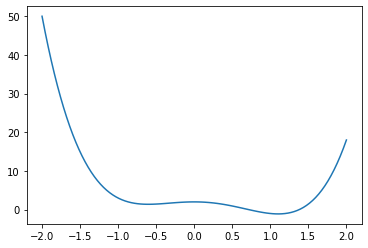

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-2, 2, 100)
plt.figure(0)
plt.plot(x, (3*x**4 - 2*x**3 - 4*x**2 + 2))
plt.show()

In [ ]:
# 目的関数の設定
def f(x):
    return (3*x**4 - 2*x**3 - 4*x**2 + 2)

In [ ]:
# 目的関数の定義(f(x)をラップするように記述)
def objective(trial): # 引数 (trial) はTrial型の値
    # 最適化する変数とその範囲を選択
    x = trial.suggest_uniform("x", -5, 5)
    # 途中の状態を保存
    ret = f(x) 
    return ret


In [ ]:
# 最適化するstudyオブジェクトを定義
study = optuna.create_study(direction="minimize") 
study.optimize(objective, # 目的関数
               n_trials=100 # 実行回数
              )


In [ ]:
print(study.best_value)
print(study.best_params)

-1.1025028051711012
{'x': 1.1291211523282156}


## LightGBMの最適化

In [ ]:
import lightgbm as lgbm
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
iris = datasets.load_iris()

data = iris.data
target = iris.target
train_x, test_x, train_y, test_y = train_test_split(data, target, random_state=0)

In [ ]:
def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': 3,
        # カテゴリの試行を行うパラメータ
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        # 整数値の試行を行うパラメータ
        'num_leavrs': trial.suggest_int('num_leaves', 10, 100),
        # 対数値の試行を行うパラメータ
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        # 連続値の試行を行うパラメータ
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0, 1),
        # 離散値の試行を行うパラメータ(qは試行を行う間隔を調整する)
        #'min_child_samples': trial.suggest_discrete_uniform('min_child_samples', 1, 10, 1)
    }
    
    train_xy = lgbm.Dataset(train_x, train_y)
    val_xy = lgbm.Dataset(test_x, test_y, reference=train_xy)

    gbm = lgbm.train(param, train_xy,valid_sets = val_xy)
    
    pred_proba = gbm.predict(test_x)
    pred = np.argmax(pred_proba, axis=1)
    
    auc = roc_auc_score(test_y, pred_proba, multi_class = 'ovr')
    return auc


study = optuna.create_study(direction='minimize')
optuna.logging.disable_default_handler()
study.optimize(objective, n_trials=100)

In [ ]:
print(study.best_value)
print(study.best_params)

0.9393322593753628
{'boosting_type': 'dart', 'num_leaves': 48, 'learning_rate': 0.003865021540313576, 'feature_fraction': 0.7218443799023337}


## Optunaの可視化

In [ ]:
from optuna import visualization

### パラメータの相互作用の可視化
* https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_contour.html

In [ ]:
visualization.plot_contour(study, params=[
    'boosting_type',
    'num_leaves',
    'learning_rate',
    'feature_fraction'])

### 全ての試行のスコアとベストスコアの可視化

In [ ]:
visualization.plot_optimization_history(study)

### ハイパーパラメータとスコアを可視化

In [ ]:
visualization.plot_parallel_coordinate(study)

### ハイパラの空間のどこを探索したか

In [ ]:
visualization.plot_slice(study)

## NNモデルの最適化

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np


BATCHSIZE = 128

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCHSIZE, shuffle=True, num_workers=2)

test_set = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=BATCHSIZE, shuffle=False, num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
#モデルの定義

#入力画像の高さと幅，畳み込み層のカーネルサイズ
in_height = 28
in_width = 28
kernel = 3


class Net(nn.Module):
  def __init__(self, trial, num_layer, mid_units, num_filters):
    super(Net, self).__init__()
    self.activation = get_activation(trial)
    #第1層
    self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=num_filters[0], kernel_size=3)])
    self.out_height = in_height - kernel +1
    self.out_width = in_width - kernel +1
    #第2層以降
    for i in range(1, num_layer):
      self.convs.append(nn.Conv2d(in_channels=num_filters[i-1], out_channels=num_filters[i], kernel_size=3))
      self.out_height = self.out_height - kernel + 1
      self.out_width = self.out_width - kernel +1
    #pooling層
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.out_height = int(self.out_height / 2)
    self.out_width = int(self.out_width / 2)
    #線形層
    self.out_feature = self.out_height * self.out_width * num_filters[num_layer - 1]
    self.fc1 = nn.Linear(in_features=self.out_feature, out_features=mid_units) 
    self.fc2 = nn.Linear(in_features=mid_units, out_features=10)

  def forward(self, x):
    for i, l in enumerate(self.convs):
      x = l(x)
      x = self.activation(x)
    x = self.pool(x)
    x = x.view(-1, self.out_feature)
    x = self.fc1(x)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [ ]:
def train(model, device, train_loader, optimizer):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

def test(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    return correct / len(test_loader.dataset)

### 最適化手法の最適化の用意

In [ ]:
import torch.optim as optim

def get_optimizer(trial, model):
  optimizer_names = ['Adam', 'MomentumSGD', 'rmsprop']
  optimizer_name = trial.suggest_categorical('optimizer', optimizer_names)
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
  if optimizer_name == optimizer_names[0]: 
    adam_lr = trial.suggest_loguniform('adam_lr', 1e-5, 1e-1)
    optimizer = optim.Adam(model.parameters(), lr=adam_lr, weight_decay=weight_decay)
  elif optimizer_name == optimizer_names[1]:
    momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)
    optimizer = optim.SGD(model.parameters(), lr=momentum_sgd_lr, momentum=0.9, weight_decay=weight_decay)
  else:
    optimizer = optim.RMSprop(model.parameters())
  return optimizer

### 活性化関数の最適化の用意

In [ ]:
def get_activation(trial):
    activation_names = ['ReLU', 'ELU']
    activation_name = trial.suggest_categorical('activation', activation_names)
    if activation_name == activation_names[0]:
        activation = F.relu
    else:
        activation = F.elu
    return activation


### optunaの目的関数の定義

In [ ]:
EPOCH = 10
def objective(trial):
  device = "cuda" if torch.cuda.is_available() else "cpu"

  #畳み込み層の数
  num_layer = trial.suggest_int('num_layer', 3, 7)

  #FC層のユニット数
  mid_units = int(trial.suggest_discrete_uniform("mid_units", 100, 500, 100))

  #各畳込み層のフィルタ数
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16)) for i in range(num_layer)]

  model = Net(trial, num_layer, mid_units, num_filters).to(device)
  optimizer = get_optimizer(trial, model)

  for step in range(EPOCH):
      # 学習
      train(model, device, train_loader, optimizer)
      # 評価
      error_rate = test(model, device, test_loader)

  return error_rate

### ハイパラ探索の実行

In [ ]:
TRIAL_SIZE = 100
# 正解率の最大化を目的にする
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=TRIAL_SIZE)

[I 2022-09-11 16:12:43,123] A new study created in memory with name: no-name-9f340117-a4f0-4ad7-8bda-572199a4d8ed
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Tria

In [ ]:
print(study.best_params)